# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.337519
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.059251 analytic: 0.059251, relative error: 9.115865e-08
numerical: -0.099978 analytic: -0.099978, relative error: 3.337524e-07
numerical: 1.169459 analytic: 1.169459, relative error: 3.409418e-08
numerical: -1.341169 analytic: -1.341169, relative error: 5.773331e-08
numerical: -0.285256 analytic: -0.285256, relative error: 3.233783e-08
numerical: 2.889594 analytic: 2.889594, relative error: 2.227785e-08
numerical: 0.089746 analytic: 0.089746, relative error: 2.009955e-07
numerical: 1.832252 analytic: 1.832252, relative error: 2.443488e-08
numerical: 0.485413 analytic: 0.485413, relative error: 9.307420e-08
numerical: 0.226461 analytic: 0.226461, relative error: 1.049439e-07
numerical: -1.252801 analytic: -1.252801, relative error: 2.133329e-08
numerical: 1.268893 analytic: 1.268893, relative error: 1.221209e-08
numerical: -0.386214 analytic: -0.386214, relative error: 3.606640e-08
numerical: -0.998816 analytic: -0.998816, relative error: 3.679592e-08
numerical: -0.215523 a

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.337519e+00 computed in 0.025019s
vectorized loss: 2.337519e+00 computed in 0.010005s
Loss difference: 0.000000
Gradient difference: 0.000000


In [44]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
best_tuning = ()
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [2.5e4, 5e4]
#learning_rates = [ 1e-7, 1e-6, 1e-5, 1e-4 ]
#regularization_strengths = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
learning_rates = np.random.uniform(10**(-8), 10**(-6), size=50)
regularization_strengths = np.random.uniform(10**(2.5), 1e4, size=50)

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for i, j in zip(learning_rates,regularization_strengths):

    softmax = Softmax()
    softmax.train(X_train, y_train, learning_rate=i, reg=j, num_iters=200, verbose=False)

    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)

    results[(i,j)] = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))

    if best_val < np.mean(y_val == y_val_pred):
        best_val = np.mean(y_val == y_val_pred)
        best_softmax = softmax
        best_tuning = (i, j)
    print(i, j)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print(best_tuning)

2.95874121578e-07 7816.63434908
1.15927768679e-07 7138.24355549
7.71283259338e-07 8659.06645188
2.06613203522e-07 4898.00328187
7.17224825229e-07 2159.72136645
1.26216845819e-07 5635.70267851
9.93946822398e-07 1505.78190616
8.9861249212e-07 3104.73479598
3.87161557587e-08 8249.441911
3.44989110199e-07 3657.63608012
8.94130615895e-07 4945.26435031
8.72446829976e-08 9364.13801508
2.35564616183e-07 4070.04068769
6.93865541575e-07 2366.66332137
2.2498265912e-07 5458.15090815
7.88200853958e-07 5797.70577957
2.00930205298e-07 2390.34767716
5.03070614536e-07 484.620208083
1.87272694892e-07 9683.29694117
6.79449191181e-08 2278.57346602
7.50241695135e-07 2922.96455359
5.03529213506e-07 7459.84721499
3.0437795413e-07 4433.34592917
1.49905666414e-07 7147.1080524
1.78042277959e-07 740.476194202
8.50446988855e-07 9738.03620582
9.72333511759e-07 6988.45718614
9.46653074997e-07 8859.38873417
4.7049637342e-07 6406.95589276
9.74134749813e-07 1814.5698256
3.65293320993e-07 3423.07262797
1.27571248207e-0

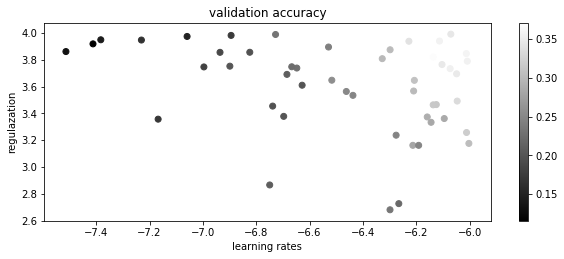

In [45]:
import math
x_scatters = [math.log10(x[0]) for x in results]
y_scatters = [math.log10(x[1]) for x in results]
#print(x_scatters)
colors = [results[x][1] for x in results]
plt.subplot(2,1,1)
plt.scatter(x_scatters,y_scatters,c = colors)

plt.colorbar()
plt.xlabel("learning rates")
plt.ylabel("regulazation")
plt.title("validation accuracy")

In [46]:

best_softmax = Softmax()
best_softmax.train(X_train, y_train, learning_rate=best_tuning[0], reg=best_tuning[1], num_iters=1000, verbose=False)


[274.51304502217698,
 265.64113249987435,
 256.01493090555164,
 247.8494926922269,
 239.37183855436066,
 231.32330828925714,
 223.81413961662011,
 216.07829856948922,
 209.03816308569773,
 201.72939026286409,
 195.79168306329956,
 188.5746501846161,
 182.5082162176289,
 176.49670606169167,
 170.5389547710451,
 165.15990614983161,
 159.30973062693528,
 154.29954554957169,
 149.40231746108276,
 144.05285843641272,
 139.45982389812232,
 134.51384743470277,
 130.24742926573012,
 126.00020585755439,
 122.1276105078057,
 117.93984909239977,
 113.75982080190724,
 110.2142067623611,
 106.61047247697881,
 102.95144563904078,
 99.616251128009935,
 96.321249568144438,
 93.225336492165425,
 90.243799896700537,
 87.194553139557144,
 84.377247287729759,
 81.485384015810894,
 78.967037582638397,
 76.410371423499313,
 73.861607086100975,
 71.505797408451969,
 69.135745907884768,
 66.915091915131583,
 64.667721392442033,
 62.669616338013711,
 60.634996028073758,
 58.650764392897734,
 56.889803042338215

In [47]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.356000


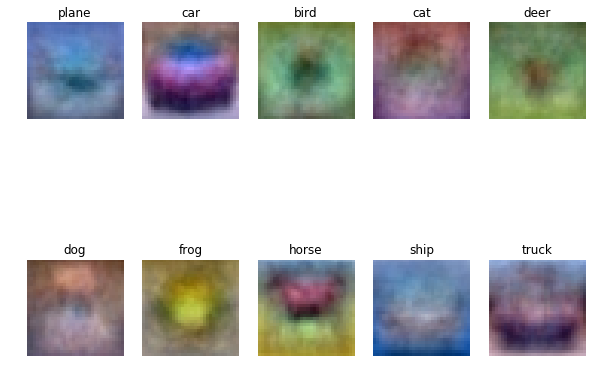

In [48]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])